# Bi-modal distribution fitting with a VAE

This notebook tries to solve the same problem as notebook `02_gaussian_mixtures.ipynb`, but with a Variational Autoencoder.

## The problem

As in the previous notebook, we have a bi-modal distribution of work activities, some of which are full-time and some part-time.

In [14]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import layers, ops

We use the same assumptions as before:

In [15]:
n_agents = 10**4
means = np.array([4, 8]) / 24
sds = np.array([0.2, 1.1]) / 24
weights = np.array([0.3, 0.7])
n_epochs = 50

... and generate our train dataset:

[[6.41527354]
 [8.69254453]
 [6.72112322]
 ...
 [8.59861073]
 [7.76726553]
 [7.86793426]]


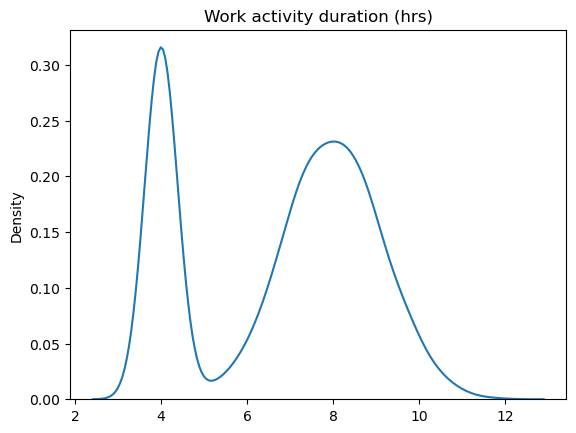

In [16]:

idist = np.random.choice([0, 1], size=n_agents, p=weights)
work_duration = (np.random.normal(loc=means[idist], scale=sds[idist]) * 24)[:, np.newaxis]
print(work_duration)
sns.kdeplot(work_duration[:, 0])
plt.title("Work activity duration (hrs)")
plt.show()

## Modelling

We adapt a VAE model from this Keras example: https://keras.io/examples/generative/vae/ .


In [17]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim))
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

# encoder
latent_dim = 2
inputs_shape = work_duration[0].shape

encoder_inputs = keras.layers.Input(shape=inputs_shape, name="inputs")
x = keras.layers.Dense(150, activation="relu", name="hidden1")(encoder_inputs)
x = keras.layers.Dense(50, activation="relu", name="hidden2")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = keras.layers.Dense(50, activation="relu")(latent_inputs)
x = keras.layers.Dense(150, activation="relu")(x)
decoder_outputs = keras.layers.Dense(np.prod(inputs_shape), activation="linear")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(keras.losses.mean_squared_error(data, reconstruction))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden1 (Dense)     │ (None, 150)       │        300 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden2 (Dense)     │ (None, 50)        │      7,550 │ hidden1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        102 │ hidden2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        102 │ hidden2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_2          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,054 (31.46 KB)

 Trainable params: 8,054 (31.46 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 150)            │         7,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,951 (31.06 KB)

 Trainable params: 7,951 (31.06 KB)

 Non-trainable params: 0 (0.00 B)

We fit the VAE model:

In [18]:

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(work_duration, epochs=n_epochs, batch_size=128)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 21.3144 - loss: 2763.8660 - reconstruction_loss: 2721.3445 - total_loss: 1067.2997
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 37.0193 - loss: 50.6185 - reconstruction_loss: 13.5628 - total_loss: 47.7061
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 32.2660 - loss: 40.6848 - reconstruction_loss: 8.3897 - total_loss: 38.3606
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 26.7978 - loss: 32.6723 - reconstruction_loss: 5.8514 - total_loss: 30.8176
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 22.0507 - loss: 26.1752 - reconstruction_loss: 4.1043 - total_loss: 24.5652
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 17.8082 - loss: 20.7372 - reconstruction_loss: 2.9159 - total_loss: 19.6876
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 14.8174 - loss: 17.0893 - reconstruction_loss: 2.2629 - total_loss: 16.3710
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━

Finally, we generate some predictions by sampling from the latent space:

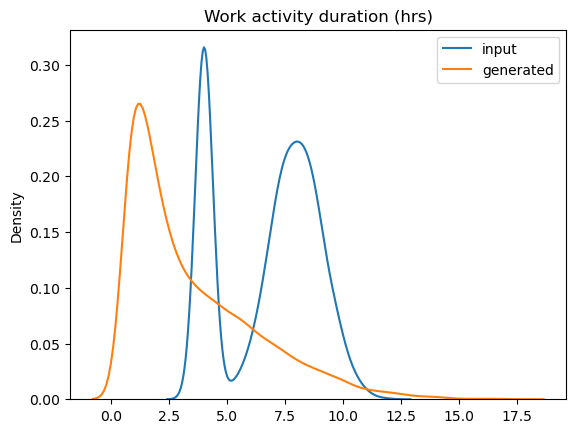

In [19]:

sampled_codings = tf.random.normal(shape=[n_agents, latent_dim])
sampled_durations = decoder(sampled_codings).numpy()

fig, ax = plt.subplots()
sns.kdeplot(pd.Series(work_duration[:, 0]), ax=ax)
sns.kdeplot(pd.Series(sampled_durations[:, 0]), ax=ax)
plt.title("Work activity duration (hrs)")
plt.legend(["input", "generated"])
plt.show()

While the above example is not able to replicate the input data well, we can achieve a much better representation if we increase the input sample size (ie `n_agents=10**5`) and/or the number of epochs (ie `n_epochs=500`). We can therefore reach a similar answer to the MND model, but it may require more time and data.